[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tanikina/low-resource-nlp-lab/blob/main/notebooks/Adapters_Intent_Classification_Tutorial.ipynb)

In [ ]:
!pip install transformers[torch]
!pip install adapters
!pip install datasets
!pip install numpy
!pip install matplotlib

In [1]:
import datasets
from transformers import AutoTokenizer
from adapters import AutoAdapterModel, AdapterConfig

import torch
from torch import nn
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Setting seed for reproducibility
seed_num = 2024
torch.manual_seed(seed_num)
np.random.seed(seed_num)

### 🗃️ Dataset Preparation
**Robot-Assisted Disaster Response** dataset consists of conversations recorded during the training sessions in the emergency response domain. The conversations are typically between several operators controlling the robots, a team leader and a mission commander. Each dialogue turn is annotated with one of the following intent labels:

| label | meaning | train | percentage | example |
| --- | --- | --- | --- | --- |
| 0 | disconfirm | 35 | 1.3% | `Ist negativ, noch nicht.` |
| | | | | Is negative, not yet. |
| 1 | order | 216 | 8.3% | `Für Sie Erkundungsauftrag: Gesamtüberblick über die Einsatzstelle. Kommen.` |
| | | | | For you, reconnaissance assignment: overall overview of the site. Come in. |
| 2 | info_provide | 979 | 37.5% | `Ich verlasse das Erdgeschoss und gehe ins erste Obergeschoss.` |
| | | | | I leave the ground floor and go to the first floor. |
| 3 | info_request | 238 | 9.1% | `Frage: Erkundungsergebnis aus der östlichen Seite des Gebäudes, kommen.` |
| | | | | Question: Exploration results from the eastern side of the building, come in. |
| 4 | call | 487 | 18.7% | `RobLW an Zugführer, kommen.` |
| | | | | RobLW to platoon commander, come in. |
| 5 | call_response | 370 | 14.2% | `Ja, hier ist Zugführer, kommen.` |
| | | | | Yes, here is the platoon commander, come in. |
| 6 | other | 43 | 1.7% | `Einen Augenblick, ich melde mich gleich.` |
| | | | | Just a moment, I will let you know soon. |
| 7 | confirm | 242 | 9.3% | `Ein Lagebild von oben, komplette Lage, und ein Lagebild zwischen den beiden Türen, verstanden.` |
| | | | | A picture from above, complete setting, and a picture between both doors, understood. |

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Defining the task and hyperparameters
task = "intent_classification"
model_name = "bert-base-multilingual-cased"
batch_size = 32
num_epochs = 20
encode_prev_turn = False

In [4]:
class DatasetPreprocessor:
    def __init__(self, tokenizer, encode_prev_turn=False):
        self.tokenizer = tokenizer
        self.encode_prev_turn = encode_prev_turn

    """Encodes the input data."""
    def encode_data(self, data):
        if self.encode_prev_turn:
            encoded = self.tokenizer([data["prev_speaker"][doc_i] + " - " + data["prev_text"][doc_i] \
                                 + " [SEP] " + data["speaker"][doc_i] + " - " + doc_tokens \
                                for doc_i, doc_tokens in enumerate(data["text"])], \
                                pad_to_max_length=True, padding="max_length", max_length=64, \
                                truncation=True, add_special_tokens=True)
        else:
            encoded = self.tokenizer([data["speaker"][doc_i] + " - " + doc_tokens for doc_i, doc_tokens in enumerate(data["text"])], \
                            pad_to_max_length=True, padding="max_length", max_length=64, truncation=True, add_special_tokens=True)
        return encoded

    """Adds columns with the previous speaker and turn text"""
    def add_prev_speaker_and_text_columns(self, task_dataset):
        prev_speaker_column = [(task_dataset["speaker"][doc_i-1] if doc_i > 0 else "Start") \
                               for doc_i in range(len(task_dataset["speaker"]))]
        task_dataset = task_dataset.add_column("prev_speaker", prev_speaker_column)
        prev_text_column = [(task_dataset["text"][doc_i-1] if doc_i > 0 else "Start.") \
                            for doc_i in range(len(task_dataset["text"]))]
        task_dataset = task_dataset.add_column("prev_text", prev_text_column)
        return task_dataset

# Defining the tokenizer and pre-processing the data
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
dp = DatasetPreprocessor(tokenizer, encode_prev_turn)

data = datasets.load_dataset("DFKI/radr_intents")

# Preparing the training data
train_task_dataset = train_task_dataset = data["train"]
if encode_prev_turn:
    train_task_dataset = dp.add_prev_speaker_and_text_columns(train_task_dataset)
train_task_dataset = train_task_dataset.map(dp.encode_data, batched=True, batch_size=batch_size)
train_task_dataset = train_task_dataset.rename_column("label","labels")

# Preparing the validation data
dev_task_dataset = dev_task_dataset = data["validation"]
if encode_prev_turn:
    dev_task_dataset = dp.add_prev_speaker_and_text_columns(dev_task_dataset)
dev_task_dataset = dev_task_dataset.map(dp.encode_data, batched=True, batch_size=batch_size)
dev_task_dataset = dev_task_dataset.rename_column("label","labels")

# Printing some examples
for sample_i, sample in enumerate(dev_task_dataset):
    if sample_i > 2:
        break
    print(sample)
    print(tokenizer.batch_decode([sample["input_ids"][:30]], skip_special_tokens=True))

# Defining the dataloaders and setting the correct format
train_task_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
dev_task_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
train_dataloader = torch.utils.data.DataLoader(train_task_dataset, batch_size=batch_size, shuffle=True)
dev_dataloader = torch.utils.data.DataLoader(dev_task_dataset, batch_size=batch_size, shuffle=False)

{'id': 0, 'speaker': 'UAV', 'text': 'UAV hat Softwareprobleme, wir versuchen es zu beheben.', 'labels': 2, 'input_ids': [101, 20138, 11779, 118, 20138, 11779, 11250, 21176, 73099, 76419, 10112, 117, 33963, 12576, 59953, 10196, 10304, 10347, 89672, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
['UAV - UAV hat Softwareprobleme, wir versuchen es zu beheben.']
{'id': 1, 'speaker': 'TL', 'text': 'Ja, verstanden.', 'labels': 2, 'input_ids': [101, 157, 11369, 118, 28248, 117, 12576, 7

### 🔌 Adapter Recap
<center>
<img src="images/bottleneck.png" alt="Bottleneck Adapter" width="200"/>
</center>
The bottleneck adapter network consists of a linear down projection, non-linearity, and up projection, followed by a residual connection. It is positioned after the multihead attention layer and/or the feedforward layer. <a href="https://adapterhub.ml/blog/2022/03/adapter-transformers-v3-unifying-efficient-fine-tuning/">https://adapterhub.ml/blog/2022/03/adapter-transformers-v3-unifying-efficient-fine-tuning/</a>

### 🚀 Training

In [5]:
model = AutoAdapterModel.from_pretrained(model_name)

label2id = {"disconfirm":0, "order":1, "info_povide":2, "info_request":3, "call":4, "call_response":5, "other":6, "confirm":7}
id2label = dict()
for k,v in label2id.items():
    id2label[v] = k

Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Active adapters: Stack[de, intent_classification]
 Epoch: 0
 Train loss: 0.6902758479118347
 Epoch: 1
 Train loss: 0.10931345820426941
 Epoch: 2
 Train loss: 0.0788424164056778
 Epoch: 3
 Train loss: 0.10862086713314056
 Epoch: 4
 Train loss: 0.15930676460266113
 Epoch: 5
 Train loss: 0.10134536027908325
 Epoch: 6
 Train loss: 0.03237571567296982
 Epoch: 7
 Train loss: 0.06760232150554657
 Epoch: 8
 Train loss: 0.04932840168476105
 Epoch: 9
 Train loss: 0.05085955932736397
 Epoch: 10
 Train loss: 0.046060673892498016
 Epoch: 11
 Train loss: 0.012366325594484806
 Epoch: 12
 Train loss: 0.014636543579399586
 Epoch: 13
 Train loss: 0.008747365325689316
 Epoch: 14
 Train loss: 0.016307339072227478
 Epoch: 15
 Train loss: 0.049739718437194824
 Epoch: 16
 Train loss: 0.033242158591747284
 Epoch: 17
 Train loss: 0.008503561839461327
 Epoch: 18
 Train loss: 0.00610558595508337
 Epoch: 19
 Train loss: 0.03791643679141998


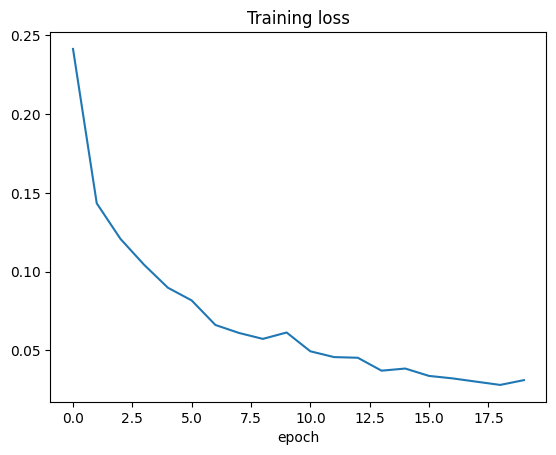

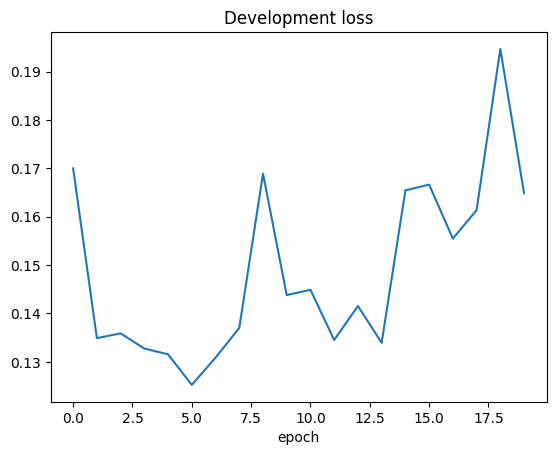

In [6]:
from adapters import AdapterConfig
from adapters.composition import Stack

# Loading the language adapters and adding the task adapter
lang_adapter_config = AdapterConfig.load("pfeiffer", reduction_factor=2)
model.load_adapter("de/wiki@ukp", config=lang_adapter_config)
model.add_adapter(task, config=AdapterConfig.load("pfeiffer"))
model.train_adapter([task])
model.active_adapters = Stack("de", task)
model.add_classification_head(task, num_labels=len(label2id), id2label=id2label, use_pooler=True)

print("Active adapters:", model.active_adapters)

# Defining the loss function and optimizer parameters
loss_function = torch.nn.BCEWithLogitsLoss()
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [{"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], \
                                 "weight_decay": 1e-4,}, \
                                {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], \
                                 "weight_decay": 0.0,},]
optimizer = torch.optim.AdamW(params=optimizer_grouped_parameters, lr=1e-3)

model.to(device)

min_dev_loss = None
dev_losses_per_epoch = []
train_losses_per_epoch = []

# Training loop
for epoch in range(num_epochs):
    train_losses = []
    # training
    for i, batch in enumerate(train_dataloader):
        for k, v in batch.items():
            batch[k] = v.to(device)
        outputs = model(batch["input_ids"], attention_mask=batch["attention_mask"])
        predictions = outputs.logits
        expected = torch.zeros(predictions.shape)
        for bi, lbl in enumerate(batch["labels"]):
            expected[bi][lbl] = 1
        expected = expected.to(device)
        predicted_val, predicted_idx = torch.max(predictions, dim=-1)
        loss = loss_function(predictions, expected)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if i % 100 == 0:
            print(f" Epoch: {epoch}")
            print(f" Train loss: {loss}")
    cur_loss = sum(train_losses)/len(train_losses)
    train_losses_per_epoch.append(cur_loss)
    
    # evaluation
    with torch.no_grad():
        dev_losses = []
        for i, batch in enumerate(dev_dataloader):
            for k, v in batch.items():
                batch[k] = v.to(device)
            outputs = model(batch["input_ids"], attention_mask=batch["attention_mask"])
            predictions = outputs.logits
            expected = torch.zeros(predictions.shape)
            for bi, lbl in enumerate(batch["labels"]):
                expected[bi][lbl] = 1
                expected = expected.to(device)
            loss = loss_function(predictions, expected)
            dev_losses.append(loss.item())
        cur_loss = sum(dev_losses)/len(dev_losses)
        dev_losses_per_epoch.append(cur_loss)
        if min_dev_loss is None or min_dev_loss > cur_loss:
            min_dev_loss = cur_loss
            model.save_adapter(task, task)

# Visualize the loss curve for training and developement data
plt.plot(train_losses_per_epoch)
plt.xlabel("epoch")
plt.title("Training loss")
plt.show()
plt.plot(dev_losses_per_epoch)
plt.xlabel("epoch")
plt.title("Development loss")
plt.show()

### ✅ Evaluation

In [7]:
# Loading English test data
!wget https://raw.githubusercontent.com/tanikina/low-resource-nlp-lab/main/datasets/english_test_radr_intents.csv

--2024-02-20 14:50:12--  https://raw.githubusercontent.com/tanikina/low-resource-nlp-lab/main/datasets/english_test_radr_intents.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2519 (2.5K) [text/plain]
Saving to: ‘english_test_radr_intents.csv’

english_test_radr_i 100%[===================>]   2.46K  --.-KB/s    in 0s      

2024-02-20 14:50:13 (12.8 MB/s) - ‘english_test_radr_intents.csv’ saved [2519/2519]



In [8]:
# Test set evaluation
import adapters.composition as ac

# Preparing the test data
test_task_dataset = test_task_dataset = data["test"]
#test_task_dataset = datasets.Dataset.from_csv("english_test_radr_intents.csv")
test_task_dataset = dp.add_prev_speaker_and_text_columns(test_task_dataset)
test_task_dataset = test_task_dataset.map(dp.encode_data, batched=True, batch_size=batch_size)
test_task_dataset = test_task_dataset.rename_column("label","labels")

test_task_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataloader = torch.utils.data.DataLoader(test_task_dataset, batch_size=1, shuffle=False)

# Loading the model and adapters for evaluation
model = AutoAdapterModel.from_pretrained(model_name)
model.load_adapter(task)
model.load_head(task)
lang_adapter_config = AdapterConfig.load("pfeiffer", reduction_factor=2)
model.load_adapter("de/wiki@ukp", config=lang_adapter_config)
model.load_adapter("en/wiki@ukp", config=lang_adapter_config)
model.active_adapters = ac.Stack("de", task) #task #ac.Stack("en", task)

print("Active adapters:", model.active_adapters)

all_labels = label2id.keys()
scores = dict()
for label in all_labels:
    scores[label] = {"tp":0, "fp":0, "fn":0}
match = 0

with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        outputs = model(batch["input_ids"], attention_mask=batch["attention_mask"])
        predictions = outputs.logits
        predicted_vals, predicted_indices = torch.max(predictions, dim=-1)
        for j in range(len(predicted_vals)):
            predicted_val = predicted_vals[j]
            predicted_idx = predicted_indices[j]
            predicted_label = id2label[predicted_idx.item()]
            gold_label = id2label[batch["labels"].item()]
            
            if predicted_label==gold_label:
                match+=1
                scores[predicted_label]["tp"]+=1
            else:
                intext = tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=True)
                # print(intext, ">>>", predicted_label, gold_label)
                scores[predicted_label]["fp"]+=1
                scores[gold_label]["fn"]+=1
            
    print("Accuracy:", round(match/len(test_dataloader),3), "matched:", match, "total:", len(test_dataloader))
    print("F1 scores:")
    f1scores = 0
    # Computing f1 scores (per label)
    for label in all_labels:
        tp = scores[label]["tp"]
        fp = scores[label]["fp"]
        fn = scores[label]["fn"]
        if (tp+fp) > 0:
            prec = tp/(tp+fp)
        else:
            prec = 0
        if (tp+fn) > 0:
            rec = tp/(tp+fn)
        else:
            rec = 0
        if (prec+rec) > 0:
            f1score = 2*prec*rec/(prec+rec)
        else:
            f1score = 0
        f1scores += f1score
        print(label, "F1:", round(f1score,3))
    # Computing macro f1 score (avg)
    print("Macro F1:", round(f1scores/len(all_labels),3))

/usr/local/lib/python3.10/dist-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


Map:   0%|          | 0/605 [00:00<?, ? examples/s]

Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Overwriting existing head 'intent_classification'


Active adapters: Stack[de, intent_classification]
Accuracy: 0.803 matched: 486 total: 605
F1 scores:
disconfirm F1: 0.615
order F1: 0.676
info_povide F1: 0.814
info_request F1: 0.921
call F1: 0.959
call_response F1: 0.883
other F1: 0.32
confirm F1: 0.472
Macro F1: 0.707


with context [German test data]:

without context [German test data]:

en + task [English test data]:

task only  [English test data]: